# Data Visualization in Python 
DA Probability & Statistics Learning Series • Python Lesson 2

<img src="https://pyxis.nymag.com/v1/imgs/0c1/267/38d1f78b4d3b94bd1b630ed7f810f3504b-07-softbank-group-05.2x.rhorizontal.w700.jpg" align="center" height="400" width="600"/>

There's always something to learn from our fellow Vision Fund portfolio companies...

*See **#da_prob_stat** for discussion during and after this tutorial.*


## Goals

- Understand the basic tools available to visualize data in Python
- Create wrapper functions around existing visualization functions to make it easier to use them
- Learn to perfrom EDA with data viz in Python
- Give Shreyas a shot at being the TA he never was

## Setup ⚙️

In [1]:
# Import dependencies
from db_utils import get_connection, get_data
import pandas as pd
import datetime

# Data viz
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns

# Regression
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics

_Note that we are importing a new function called `get_data()` from `db_utils`. This is a wrapper around the the `pd.read_sql()` function you've seen before. Type `get_data()` and hit `Shift+Tab` to see how it works._

**WARM UP:** Complete `get_data()` function

### Throwback ⏪

In the homework from the previous Python lesson, we calculated the OTP of Air shipments in March 2020

In [6]:
# Get the database connection and cursor objects
conn, cur = get_connection()

# Get data from the otp.sql file
hw_df = get_data('otp.sql', 'file', conn)

# Rename column headers
hw_df.columns = [
    'shipment_id', 
    'completion_date', 
    'mode_blended', 
    'transit_on_time', 
    'all_transit_milestones_completed'
]

In [7]:
# Create an int version of transit_on_time and convert completion date from string to date
hw_df['transit_on_time'] = hw_df['transit_on_time'].apply(lambda x: x == 'True')
hw_df['transit_on_time_int'] = hw_df['transit_on_time'].apply(lambda x: int(x))

hw_df['completion_dt'] = [datetime.datetime.strptime(i, '%Y-%m-%d') for i in hw_df['completion_date']]
hw_df['completion_month'] = hw_df['completion_dt'].dt.month
hw_df['completion_year'] = hw_df['completion_dt'].dt.year

In [13]:
air_march_otp = \
hw_df[
    (hw_df['all_transit_milestones_completed'] == 'Yes') &
    (hw_df['completion_month'] == 3) &
    (hw_df['completion_year'] == 2020) &
    (hw_df['mode_blended'] == 'Air')
].\
groupby(by=['mode_blended', 'completion_month', 'completion_year']).\
agg({'transit_on_time_int' : 'mean'}).\
reset_index()

air_march_otp.columns = ['mode', 'month', 'year', 'otp_percent']

print(f'Air Shipments OTP - March 2020: {air_march_otp.loc[0,"otp_percent"]*100}%')

Air Shipments OTP - March 2020: 36.0%


## Motivating Question 🤔

> What has OTP looked like for Air shipments over the course of 2020? Have things gotten better since Nate joined the team?

**TODO**

In [14]:
air_otp = \
hw_df[
    (hw_df['all_transit_milestones_completed'] == 'Yes') &
    (hw_df['mode_blended'] == 'Air')
].\
groupby(by=['mode_blended', 'completion_month', 'completion_year']).\
agg({'transit_on_time_int' : 'mean'}).\
reset_index()

air_otp.columns = ['mode', 'month', 'year', 'otp_percent']

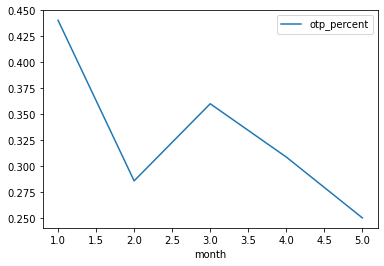

In [15]:
air_otp.plot('month', 'otp_percent')

And there's our first chart! It's a pretty 💩chart but it's a chart nonetheless... Also, Nate has evidently had a **HUGE** impact on the team in just a few months of being here.
<br>
But...
<br>
What even is this chart...

### Open Questions ❓
- How does `.plot()` work?
- Shreyas can you **please** label your axes for me?
- Why does this chart look so 💩?

Let's dive in!

## Tools for Data Visualization

> Great leaders don't blame the tools they are given. They work to sharpen them. - _Simon Sinek_

There are several tools we could use for data viz in Python, including `matplotlib`, `seaborn`, `plotly`, and `bokeh`. They're all quriky in their own ways though, and as analysts, we need to know how to make them work for us.

In this session, we will grapple with two modules: `matplotlib.pyplot` and `seaborn`.

_Aside: I personally always get confused between `Module`, `Package`, and `Library`. Here's what the [internet](https://www.quora.com/What-is-the-difference-between-Python-modules-packages-libraries-and-frameworks) says:_
- **Module**: Any `.py` file that contains functions, Classes, global variables, etc. is considered a _module_. We've seen these before a lot: `pandas`, `numpy`, `datetime`, and even the custom created `db_utils` are all _modules_.
- **Package/Library**: In Python, these are synonymous. They are directories of other _packages/libraries_ and _modules_ that organize related tools and files in the same place. 
    - We can use the command `import library_name` to get all the _packages_ residing within `library_name`
    - We can also use the command `import library_name.module_name` or `from library_name import module_name` to access a specific _module_ in a _library_

### Matplotlib 📚

**INSERT EXPLANATION**
- pyplot is the most popular module in matplotlib that makes MATLAB style plotting available in Python
- `plot()` function in `pyplot` can be called in multiple ways
    - `df.plot()` where `df` is some `pandas` `DataFrame` object
    - `ax.plot()` on any `matplotlib` `Axes` object
    - `plt.plot()` where `plt` refers to the `pyplot` module

Text(0.5, 1.0, 'Hello')

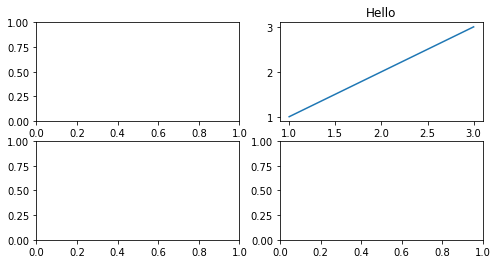

In [20]:
fig, ax = plt.subplots(2,2,figsize=(8,4)) # this is the same as "fig, ax = plt.subplots(1, 1, figsize=(8,4))"

ax[0,1].plot([1,2,3], [1,2,3])
ax[0,1].set_title("Hello")